# Autoencoder

In [1]:
import sys
sys.path.append("models/")
from setup import out_dir, data_dir, image_dir, model_dir
%load_ext autoreload
%autoreload 2

import os
from datetime import datetime
import json
from collections import OrderedDict
import logging
import argparse
import numpy as np
import random
import matplotlib.pyplot as plt
import glob
import pandas as pd

import torch
import torch.nn as nn
import torch.optim
import torch.utils.data
import torch.backends.cudnn
import torchvision.utils
import torchvision.transforms
import torch.nn.functional as F

try:
    from tensorboardX import SummaryWriter
    is_tensorboard_available = True
except Exception:
    is_tensorboard_available = False

from dataloader import image_loader
from autoencoder import Autoencoder_raw
from BM1_util_train_test import load_model, train, test
from exp_version import get_hp_from_version_code


torch.backends.cudnn.benchmark = True

logging.basicConfig(
    format='[%(asctime)s %(name)s %(levelname)s] - %(message)s',
    datefmt='%Y/%m/%d %H:%M:%S',
    level=logging.DEBUG)
logger = logging.getLogger(__name__)

global_step = 0

In [3]:
zoomlevel = 'zoom15'
output_dim = 3
model_run_date = "2208"
sampling = 'stratified'
data_version='1571'

v2 = 1 
_, lr, wd = get_hp_from_version_code(None,v2)

device = torch.device("cuda:1" if torch.cuda.is_available() else "cuda:2")

In [4]:
args = {'image_size': 224, 
        'depth': -1,
       'base_channels':64,
       'output_dim':output_dim,
       'num_demo_vars':0,
       'cardinality':1,
       'epochs':200,
       'batch_size':16,
       'base_lr':lr,
       'weight_decay':wd,
       'momentum': 0.9,
       'nesterov': True,
       'milestones': '[50,100]',
       'lr_decay':0.1,
       'seed': 1234,
       'outdir':out_dir,
       'num_workers':8,
       'tensorboard':False,
       'save':True}

model_config = OrderedDict([
    ('arch', 'resnext'),
    ('depth', args['depth']),
    ('base_channels', args['base_channels']),
    ('cardinality', args['cardinality']),
    ('output_dim', args['output_dim']),
    ('num_demo_vars', args['num_demo_vars'])
])

optim_config = OrderedDict([
    ('epochs', args['epochs']),
    ('batch_size', args['batch_size']),
    ('base_lr', args['base_lr']),
    ('weight_decay', args['weight_decay']),
    ('momentum', args['momentum']),
    ('nesterov', args['nesterov']),
    ('milestones', json.loads(args['milestones'])),
    ('lr_decay', args['lr_decay']),
])

data_config = OrderedDict([
    ('dataset', 'CIFAR10'),
    ('image_size', args['image_size'])
])

run_config = OrderedDict([
    ('seed', args['seed']),
    ('outdir', args['outdir']),
    ('save', args['save']),
    ('num_workers', args['num_workers']),
    ('tensorboard', args['tensorboard']),
])

config = OrderedDict([
    ('model_config', model_config),
    ('optim_config', optim_config),
    ('data_config', data_config),
    ('run_config', run_config),
])

In [5]:
# parse command line arguments
#config = parse_args()
#logger.info(json.dumps(config, indent=2))

model_name = datetime.now().strftime("%m%d-%H%M")

run_config = config['run_config']
optim_config = config['optim_config']

# TensorBoard SummaryWriter
writer = SummaryWriter(model_name) if run_config['tensorboard'] else None

# set random seed
seed = run_config['seed']
torch.manual_seed(seed)
np.random.seed(seed)
random.seed(seed)

# create output directory
outdir = run_config['outdir']
if not os.path.exists(outdir):
    os.makedirs(outdir)

# save config as json file in output directory
outpath = os.path.join(outdir, 'config.json')
with open(outpath, 'w') as fout:
    json.dump(config, fout, indent=2)

In [6]:
# data loaders
train_loader, test_loader = image_loader(image_dir+zoomlevel+"/", data_dir, optim_config['batch_size'], 
                                         run_config['num_workers'], 
                                         data_config['image_size'], data_version=data_version, sampling=sampling, 
                                         recalculate_normalize=False)

28278 images in dataset
3142 images in dataset


In [7]:
criterion = nn.MSELoss(reduction='mean')
# criterion = my_loss

In [8]:
# model
config['model_config']['input_shape'] = (1,3,data_config['image_size'],data_config['image_size'])

encoder = load_model(config['model_config']['arch'], 'Encoder', config['model_config'])
encoder = encoder.to(device)

config['model_config']['input_shape'] = [1,2048,config['model_config']['output_dim'],config['model_config']['output_dim']]

config['model_config']['conv_shape'] = [data_config['image_size']//32,data_config['image_size']//32]
config['model_config']['output_channels'] = 3

decoder = load_model(config['model_config']['arch'], 'Decoder', config['model_config'])
decoder = decoder.to(device)

config['encoder'] = encoder
config['decoder'] = decoder
model = load_model('autoencoder','Autoencoder_raw', config)
model = model.to(device)

n_params = sum([param.view(-1).size()[0] for param in encoder.parameters()]) +\
           sum([param.view(-1).size()[0] for param in decoder.parameters()])
logger.info('n_params: {}'.format(n_params))

# optimizer
optimizer = torch.optim.SGD(
    model.parameters(),
    lr=optim_config['base_lr'],
    momentum=optim_config['momentum'],
    weight_decay=optim_config['weight_decay'],
    nesterov=optim_config['nesterov'])

scheduler = torch.optim.lr_scheduler.MultiStepLR(
    optimizer,
    milestones=optim_config['milestones'],
    gamma=optim_config['lr_decay'])

ref1 = 0
ref2 = 0

train_loss_list = []
test_loss_list = []

train_flag = True

for epoch in range(optim_config['epochs']):

    loss_ = train(epoch, model, optimizer, criterion, train_loader, run_config,
         writer, device, logger=logger)
    train_loss_list.append(loss_)

#     scheduler.step()

    test_loss_ = test(epoch, model, criterion, test_loader, run_config,
                    writer, device, logger, return_output=False)
    test_loss_list.append(test_loss_)

    if epoch % 5 == 0:
        if epoch > 50:
            if (np.abs(loss_ - ref1)/ref1<0.005) & (np.abs(loss_ - ref2)/ref2<0.005):
                print("Early stopping at epoch", epoch)
                break
            if (ref1 < loss_) & (ref1 < ref2):
                print("Diverging. stop.")
                train_flag = False
                break
            if loss_ < best:
                best = loss_
                best_test = test_loss_
                best_epoch = epoch
        else:
            best = loss_
            best_test = test_loss_
            best_epoch = epoch

        ref2 = ref1
        ref1 = loss_

        if (config['run_config']['save']) & (best_epoch==epoch):
            torch.save({'epoch': epoch,
                'model_state_dict': model.state_dict(),
                'optimizer_state_dict': optimizer.state_dict(),
                'train_loss': best,
                'test_loss': best_test,
                'config': config},
                model_dir+"AE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v2)+"_"+
                       str(model_run_date)+"_"+str(epoch)+".pt")
                
if config['run_config']['save']:
    files = glob.glob(model_dir+"AE_"+zoomlevel+"_"+str(model_config['output_dim']**2*2048)+"_"+str(v2)+"_"+
                          str(model_run_date)+"_*.pt")    
    for f in files:
        e = int(f.split("_")[-1].split(".")[0])
        if e != best_epoch:
            os.remove(f)
            
    with open(out_dir+"AE_train.csv", "a") as f:
        f.write("%s,%s,%s,%.2E,%.2E,%d,%.4f,%.4f,%d\n" % (v2, model_run_date, sampling, lr, wd, best_epoch, best, best_test, train_flag))

if run_config['tensorboard']:
    outpath = os.path.join(outdir, 'all_scalars.json')
    writer.export_scalars_to_json(outpath)

[2022/08/12 10:22:04 __main__ INFO] - n_params: 31961862
[2022/08/12 10:22:04 __main__ INFO] - Train 0
[2022/08/12 10:26:26 __main__ INFO] - Epoch 0 Step 1767/1768 Train Loss 0.62493200
[2022/08/12 10:26:26 __main__ INFO] - Test 0
[2022/08/12 10:26:37 __main__ INFO] - Epoch 0 Test Loss 0.55312518
[2022/08/12 10:26:37 __main__ INFO] - Elapsed 10.17
[2022/08/12 10:26:37 __main__ INFO] - Train 1
[2022/08/12 10:31:09 __main__ INFO] - Epoch 1 Step 1767/1768 Train Loss 0.55517308
[2022/08/12 10:31:09 __main__ INFO] - Test 1
[2022/08/12 10:31:19 __main__ INFO] - Epoch 1 Test Loss 0.53299363
[2022/08/12 10:31:19 __main__ INFO] - Elapsed 10.09
[2022/08/12 10:31:19 __main__ INFO] - Train 2
[2022/08/12 10:35:55 __main__ INFO] - Epoch 2 Step 1767/1768 Train Loss 0.54316998
[2022/08/12 10:35:55 __main__ INFO] - Test 2
[2022/08/12 10:36:05 __main__ INFO] - Epoch 2 Test Loss 0.52379150
[2022/08/12 10:36:05 __main__ INFO] - Elapsed 10.00
[2022/08/12 10:36:05 __main__ INFO] - Train 3
[2022/08/12 10:40:

[2022/08/12 12:36:20 __main__ INFO] - Epoch 27 Test Loss 0.45677517
[2022/08/12 12:36:20 __main__ INFO] - Elapsed 10.28
[2022/08/12 12:36:20 __main__ INFO] - Train 28
[2022/08/12 12:40:55 __main__ INFO] - Epoch 28 Step 1767/1768 Train Loss 0.47072653
[2022/08/12 12:40:55 __main__ INFO] - Test 28
[2022/08/12 12:41:06 __main__ INFO] - Epoch 28 Test Loss 0.45717619
[2022/08/12 12:41:06 __main__ INFO] - Elapsed 10.30
[2022/08/12 12:41:06 __main__ INFO] - Train 29
[2022/08/12 12:45:42 __main__ INFO] - Epoch 29 Step 1767/1768 Train Loss 0.46950247
[2022/08/12 12:45:42 __main__ INFO] - Test 29
[2022/08/12 12:45:52 __main__ INFO] - Epoch 29 Test Loss 0.45491878
[2022/08/12 12:45:52 __main__ INFO] - Elapsed 10.57
[2022/08/12 12:45:52 __main__ INFO] - Train 30
[2022/08/12 12:50:29 __main__ INFO] - Epoch 30 Step 1767/1768 Train Loss 0.46865999
[2022/08/12 12:50:29 __main__ INFO] - Test 30
[2022/08/12 12:50:40 __main__ INFO] - Epoch 30 Test Loss 0.45389269
[2022/08/12 12:50:40 __main__ INFO] - Ela

[2022/08/12 14:50:27 __main__ INFO] - Test 55
[2022/08/12 14:50:37 __main__ INFO] - Epoch 55 Test Loss 0.43367496
[2022/08/12 14:50:37 __main__ INFO] - Elapsed 10.42
[2022/08/12 14:50:41 __main__ INFO] - Train 56
[2022/08/12 14:55:14 __main__ INFO] - Epoch 56 Step 1767/1768 Train Loss 0.44563555
[2022/08/12 14:55:14 __main__ INFO] - Test 56
[2022/08/12 14:55:25 __main__ INFO] - Epoch 56 Test Loss 0.43282688
[2022/08/12 14:55:25 __main__ INFO] - Elapsed 10.48
[2022/08/12 14:55:25 __main__ INFO] - Train 57
[2022/08/12 15:00:01 __main__ INFO] - Epoch 57 Step 1767/1768 Train Loss 0.44456092
[2022/08/12 15:00:01 __main__ INFO] - Test 57
[2022/08/12 15:00:11 __main__ INFO] - Epoch 57 Test Loss 0.43510417
[2022/08/12 15:00:11 __main__ INFO] - Elapsed 10.35
[2022/08/12 15:00:11 __main__ INFO] - Train 58
[2022/08/12 15:04:47 __main__ INFO] - Epoch 58 Step 1767/1768 Train Loss 0.44374953
[2022/08/12 15:04:47 __main__ INFO] - Test 58
[2022/08/12 15:04:57 __main__ INFO] - Epoch 58 Test Loss 0.4379

[2022/08/12 17:03:46 __main__ INFO] - Epoch 83 Step 1767/1768 Train Loss 0.42965722
[2022/08/12 17:03:46 __main__ INFO] - Test 83
[2022/08/12 17:03:56 __main__ INFO] - Epoch 83 Test Loss 0.41601848
[2022/08/12 17:03:56 __main__ INFO] - Elapsed 10.27
[2022/08/12 17:03:56 __main__ INFO] - Train 84
[2022/08/12 17:08:31 __main__ INFO] - Epoch 84 Step 1767/1768 Train Loss 0.42772404
[2022/08/12 17:08:31 __main__ INFO] - Test 84
[2022/08/12 17:08:42 __main__ INFO] - Epoch 84 Test Loss 0.41424368
[2022/08/12 17:08:42 __main__ INFO] - Elapsed 10.28
[2022/08/12 17:08:42 __main__ INFO] - Train 85
[2022/08/12 17:13:16 __main__ INFO] - Epoch 85 Step 1767/1768 Train Loss 0.42822319
[2022/08/12 17:13:17 __main__ INFO] - Test 85
[2022/08/12 17:14:14 __main__ INFO] - Epoch 85 Test Loss 0.41391187
[2022/08/12 17:14:14 __main__ INFO] - Elapsed 57.05
[2022/08/12 17:14:16 __main__ INFO] - Train 86
[2022/08/12 17:20:37 __main__ INFO] - Epoch 86 Step 1767/1768 Train Loss 0.42756516
[2022/08/12 17:20:37 __ma

[2022/08/12 19:14:40 __main__ INFO] - Elapsed 10.37
[2022/08/12 19:14:41 __main__ INFO] - Train 111
[2022/08/12 19:19:14 __main__ INFO] - Epoch 111 Step 1767/1768 Train Loss 0.41136133
[2022/08/12 19:19:14 __main__ INFO] - Test 111
[2022/08/12 19:19:25 __main__ INFO] - Epoch 111 Test Loss 0.39979013
[2022/08/12 19:19:25 __main__ INFO] - Elapsed 10.39
[2022/08/12 19:19:25 __main__ INFO] - Train 112
[2022/08/12 19:23:59 __main__ INFO] - Epoch 112 Step 1767/1768 Train Loss 0.41188461
[2022/08/12 19:23:59 __main__ INFO] - Test 112
[2022/08/12 19:24:09 __main__ INFO] - Epoch 112 Test Loss 0.40057141
[2022/08/12 19:24:09 __main__ INFO] - Elapsed 10.36
[2022/08/12 19:24:09 __main__ INFO] - Train 113
[2022/08/12 19:28:43 __main__ INFO] - Epoch 113 Step 1767/1768 Train Loss 0.41134385
[2022/08/12 19:28:43 __main__ INFO] - Test 113
[2022/08/12 19:28:53 __main__ INFO] - Epoch 113 Test Loss 0.39801114
[2022/08/12 19:28:53 __main__ INFO] - Elapsed 10.35
[2022/08/12 19:28:53 __main__ INFO] - Train 1

[2022/08/12 21:26:56 __main__ INFO] - Epoch 138 Step 1767/1768 Train Loss 0.39696322
[2022/08/12 21:26:56 __main__ INFO] - Test 138
[2022/08/12 21:27:07 __main__ INFO] - Epoch 138 Test Loss 0.38390386
[2022/08/12 21:27:07 __main__ INFO] - Elapsed 10.42
[2022/08/12 21:27:07 __main__ INFO] - Train 139
[2022/08/12 21:31:40 __main__ INFO] - Epoch 139 Step 1767/1768 Train Loss 0.39577622
[2022/08/12 21:31:40 __main__ INFO] - Test 139
[2022/08/12 21:31:51 __main__ INFO] - Epoch 139 Test Loss 0.38345542
[2022/08/12 21:31:51 __main__ INFO] - Elapsed 10.40
[2022/08/12 21:31:51 __main__ INFO] - Train 140
[2022/08/12 21:36:24 __main__ INFO] - Epoch 140 Step 1767/1768 Train Loss 0.39531260
[2022/08/12 21:36:24 __main__ INFO] - Test 140
[2022/08/12 21:36:35 __main__ INFO] - Epoch 140 Test Loss 0.38390888
[2022/08/12 21:36:35 __main__ INFO] - Elapsed 10.41
[2022/08/12 21:36:35 __main__ INFO] - Train 141
[2022/08/12 21:41:08 __main__ INFO] - Epoch 141 Step 1767/1768 Train Loss 0.39546021
[2022/08/12 

[2022/08/12 23:34:32 __main__ INFO] - Test 165
[2022/08/12 23:34:42 __main__ INFO] - Epoch 165 Test Loss 0.37658614
[2022/08/12 23:34:42 __main__ INFO] - Elapsed 10.50
[2022/08/12 23:34:43 __main__ INFO] - Train 166
[2022/08/12 23:39:15 __main__ INFO] - Epoch 166 Step 1767/1768 Train Loss 0.38044851
[2022/08/12 23:39:15 __main__ INFO] - Test 166
[2022/08/12 23:39:25 __main__ INFO] - Epoch 166 Test Loss 0.37063632
[2022/08/12 23:39:25 __main__ INFO] - Elapsed 10.36
[2022/08/12 23:39:25 __main__ INFO] - Train 167
[2022/08/12 23:43:58 __main__ INFO] - Epoch 167 Step 1767/1768 Train Loss 0.38101897
[2022/08/12 23:43:58 __main__ INFO] - Test 167
[2022/08/12 23:44:08 __main__ INFO] - Epoch 167 Test Loss 0.36550113
[2022/08/12 23:44:08 __main__ INFO] - Elapsed 10.35
[2022/08/12 23:44:08 __main__ INFO] - Train 168
[2022/08/12 23:48:41 __main__ INFO] - Epoch 168 Step 1767/1768 Train Loss 0.38013010
[2022/08/12 23:48:41 __main__ INFO] - Test 168
[2022/08/12 23:48:51 __main__ INFO] - Epoch 168 Te

[2022/08/13 01:41:55 __main__ INFO] - Elapsed 10.38
[2022/08/13 01:41:55 __main__ INFO] - Train 193
[2022/08/13 01:46:27 __main__ INFO] - Epoch 193 Step 1767/1768 Train Loss 0.36600866
[2022/08/13 01:46:27 __main__ INFO] - Test 193
[2022/08/13 01:46:38 __main__ INFO] - Epoch 193 Test Loss 0.35560703
[2022/08/13 01:46:38 __main__ INFO] - Elapsed 10.32
[2022/08/13 01:46:38 __main__ INFO] - Train 194
[2022/08/13 01:51:10 __main__ INFO] - Epoch 194 Step 1767/1768 Train Loss 0.36413377
[2022/08/13 01:51:10 __main__ INFO] - Test 194
[2022/08/13 01:51:20 __main__ INFO] - Epoch 194 Test Loss 0.34977614
[2022/08/13 01:51:20 __main__ INFO] - Elapsed 10.38
[2022/08/13 01:51:20 __main__ INFO] - Train 195
[2022/08/13 01:55:52 __main__ INFO] - Epoch 195 Step 1767/1768 Train Loss 0.36487105
[2022/08/13 01:55:52 __main__ INFO] - Test 195
[2022/08/13 01:56:03 __main__ INFO] - Epoch 195 Test Loss 0.34919630
[2022/08/13 01:56:03 __main__ INFO] - Elapsed 10.36
[2022/08/13 01:56:03 __main__ INFO] - Train 1

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizThreeSymBol.ttf', name='STIXSizeThreeSym', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/cmss10.ttf', name='cmss10', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizOneSymReg.ttf', name='STIXSizeOneSym', style='norm

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizTwoSymReg.ttf', name='STIXSizeTwoSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXSizFiveSymReg.ttf', name='STIXSizeFiveSym', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneral.ttf', name='STIXGeneral', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: sco

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/droid/DroidSansFallbackFull.ttf', name='Droid Sans Fallback', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/pagul/Pagul.ttf', name='Pagul', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/Rekha.ttf', name='Rekha', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/UbuntuMono-BI.ttf', name='Ubuntu Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist.ttf', name='Tlwg Typist', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda.ttf', name='Garuda', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-Italic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSansNarrow-Bold.ttf', name='Liberation Sans Narrow', style='normal', variant='normal', weight=700, stretch='condensed

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/padmaa-Medium-0.5.ttf', name='padmaa', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstDigital.ttf', name='KacstDigital', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSerif-Italic.ttf', name='DejaVu Serif', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist-Bold.ttf', name='Tlwg Typist', style='normal', variant='normal', weight=700, stretch='normal', size='scal

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypist-Oblique.ttf', name='Tlwg Typist', style='oblique', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/sinhala/lklug.ttf', name='LKLUG', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-Oblique.ttf', name='Garuda', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Manjari-Regular.otf', name='Manjari', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSansBold.ttf', name='FreeSans', style='normal', variant='normal', weight=600, stretch='normal', size='scalable')) = 10.24
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-punjabi/Lohit-Gurmukhi.ttf', name='Lohit Gurmukhi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/padauk/Padauk-Regular.ttf', name='Padauk', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation/LiberationSerif-Bold.ttf', name='Liberation Serif', style='normal', variant='normal', weight=700, stretch='normal', size=

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstTitleL.ttf', name='KacstTitleL', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstPen.ttf', name='KacstPen', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstBook.ttf', name='KacstBook', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Norasi.ttf', name='Norasi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-telu-extra/Pothana2000.ttf', name='Pothana2000', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/Gubbi/Gubbi.ttf', name='Gubbi', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstArt.ttf', name='KacstArt', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Sawasdee-BoldOblique.ttf', name='Sawasdee', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022/07/16

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/STIXGeneralItalic.ttf', name='STIXGeneral', style='italic', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Bold.ttf', name='DejaVu Sans Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/home/jtl/anaconda3/envs/qingyi/lib/python3.8/site-packages/matplotlib/mpl-data/fonts/ttf/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/07/16 22:48:31 matplotlib.font_manager DEB

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSerif-Regular.ttf', name='Liberation Serif', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst-one/KacstOne-Bold.ttf', name='KacstOne', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationSans-BoldItalic.ttf', name='Liberation Sans', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/freefont/FreeSerif.ttf', name='FreeSerif', style='normal', variant='normal', weight=400, stret

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-M.ttf', name='Ubuntu', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgMono.ttf', name='Tlwg Mono', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/opentype/noto/NotoSansCJK-Regular.ttc', name='Noto Sans CJK JP', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ttf-khmeros-core/KhmerOSsys.ttf', name='Khmer OS System', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-Bold.ttf', name='Liberation Mono', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/fonts-gujr-extra/aakar-medium.ttf', name='aakar', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Kinnari-Oblique.ttf', name='Kinnari', style='oblique', variant='normal', weight=500, stretch='normal', size='scalable')) = 11.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSans-BoldOblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=700, stretch='normal'

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-BoldItalic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/opentype/malayalam/Manjari-Thin.otf', name='Manjari', style='normal', variant='normal', weight=100, stretch='normal', size='scalable')) = 10.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter-Oblique.ttf', name='Tlwg Typewriter', style='oblique', variant='normal', weight=400, stretch='normal', size='scalable')) = 11.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansMono-Oblique.ttf', name='DejaVu Sans Mono', style='oblique', variant='normal', weight=4

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa.ttf', name='Purisa', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Garuda-BoldOblique.ttf', name='Garuda', style='oblique', variant='normal', weight=700, stretch='normal', size='scalable')) = 11.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter-Bold.ttf', name='Tlwg Typewriter', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/liberation2/LiberationMono-Italic.ttf', name='Liberation Mono', style='italic', variant='normal', weight=400, stretch='normal', size='scalable

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/TlwgTypewriter.ttf', name='Tlwg Typewriter', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Purisa-Bold.ttf', name='Purisa', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/kacst/KacstDecorative.ttf', name='KacstDecorative', style='normal', variant='normal', weight=500, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/dejavu/DejaVuSansCondensed-Oblique.ttf', name='DejaVu Sans', style='oblique', variant='normal', weight=400, stretch='condensed', size='

[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/Nakula/nakula.ttf', name='Nakula', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/ubuntu/Ubuntu-L.ttf', name='Ubuntu', style='normal', variant='normal', weight=300, stretch='normal', size='scalable')) = 10.145
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/tlwg/Laksaman-Bold.ttf', name='Laksaman', style='normal', variant='normal', weight=700, stretch='normal', size='scalable')) = 10.335
[2022/07/16 22:48:31 matplotlib.font_manager DEBUG] - findfont: score(FontEntry(fname='/usr/share/fonts/truetype/lohit-telugu/Lohit-Telugu.ttf', name='Lohit Telugu', style='normal', variant='normal', weight=400, stretch='normal', size='scalable')) = 10.05
[2022/07/16 22:48:3

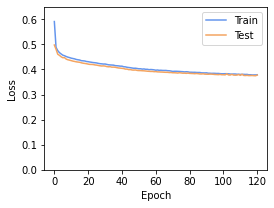

In [9]:
fig, ax = plt.subplots(figsize=(4,3))
ax.plot(train_loss_list, color='cornflowerblue', label='Train')
ax.plot(test_loss_list, color='sandybrown', label='Test')
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")
ax.set_ylim([0, 1.1*np.max(train_loss_list+test_loss_list)])
ax.legend()
plt.show()
fig.savefig(out_dir+"training_plots/AE_"+model_run_date+".png", bbox_inches='tight')

## Reconstruction Results

In [9]:
device = torch.device("cuda:1" if torch.cuda.is_available() else "cuda:1")
return_images = test(epoch, model, criterion, test_loader, run_config, writer, device, logger, return_output=True)

from dataloader import ImageDataset
transform = torchvision.transforms.Compose([
    torchvision.transforms.ToTensor(),
    torchvision.transforms.CenterCrop(data_config['image_size'])])

testset = ImageDataset(image_dir+zoomlevel+"/", data_dir, train=False, transform=transform, sampling=sampling)

[2022/02/05 23:29:56 __main__ INFO] - Test 160
[2022/02/05 23:30:01 __main__ INFO] - Epoch 160 Test Loss 0.33269426
[2022/02/05 23:30:01 __main__ INFO] - Elapsed 3.23


In [10]:
# Reverse Normalization
# Satellite image
inv_normalize = torchvision.transforms.Normalize(
    mean=[-0.3733/0.2173, -0.3991/0.2055, -0.3711/0.2143],
    std=[1/0.2173, 1/0.2055, 1/0.2143]
)

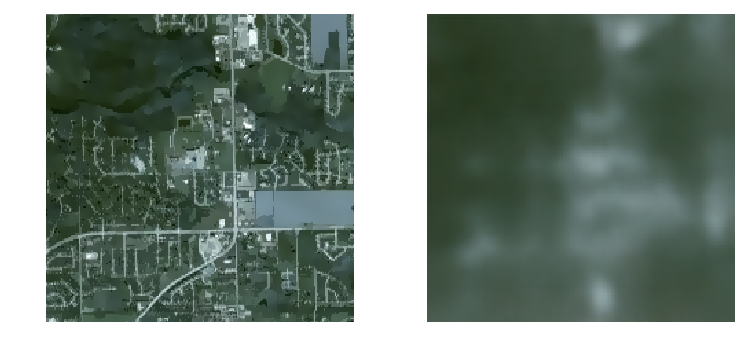

In [12]:
plot_image = 119
test_output_orig = inv_normalize(return_images[plot_image])

fig, ax = plt.subplots(1, 2, figsize=(9,4))
ax[0].imshow(testset[plot_image][1].permute(1, 2, 0))
ax[0].axis('off')
ax[1].imshow(test_output_orig.cpu().detach().permute(1, 2, 0))
ax[1].axis('off')
plt.show()